### Simple model, normal learning loop.

Epoch [0/300], Step [200/938], d_loss: 0.5290, g_loss: 1.3034, D(x): 0.88, D(G(z)): 0.29, D Real Acc: 0.94, D Fake Acc: 0.98
Epoch [0/300], Step [400/938], d_loss: 0.4634, g_loss: 1.7875, D(x): 0.90, D(G(z)): 0.26, D Real Acc: 0.97, D Fake Acc: 0.98
Epoch [0/300], Step [600/938], d_loss: 0.2624, g_loss: 2.7335, D(x): 0.93, D(G(z)): 0.14, D Real Acc: 0.98, D Fake Acc: 0.97
Epoch [0/300], Step [800/938], d_loss: 0.6341, g_loss: 1.4730, D(x): 0.82, D(G(z)): 0.27, D Real Acc: 0.86, D Fake Acc: 0.86
Epoch [1/300], Step [200/938], d_loss: 0.7388, g_loss: 1.7793, D(x): 0.77, D(G(z)): 0.23, D Real Acc: 0.75, D Fake Acc: 0.97
Epoch [1/300], Step [400/938], d_loss: 0.6189, g_loss: 1.7299, D(x): 0.78, D(G(z)): 0.22, D Real Acc: 0.78, D Fake Acc: 0.95
Epoch [1/300], Step [600/938], d_loss: 0.6058, g_loss: 2.0050, D(x): 0.77, D(G(z)): 0.19, D Real Acc: 0.77, D Fake Acc: 0.97
Epoch [1/300], Step [800/938], d_loss: 0.4722, g_loss: 2.0444, D(x): 0.86, D(G(z)): 0.22, D Real Acc: 0.89, D Fake Acc: 0.95


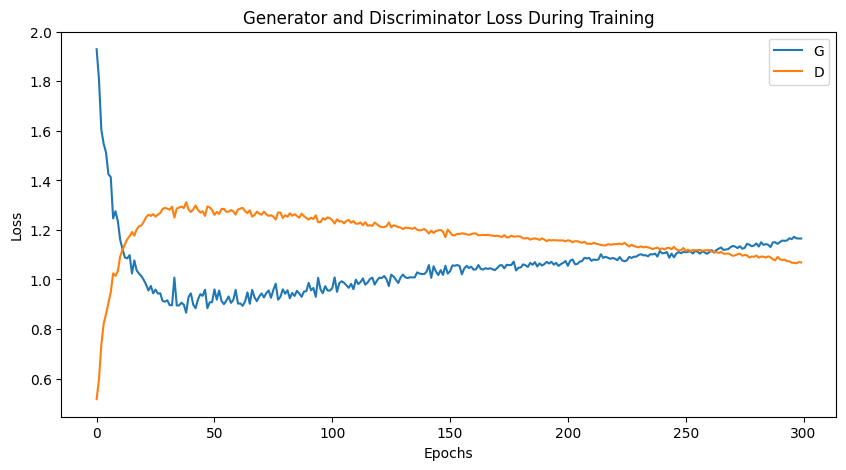

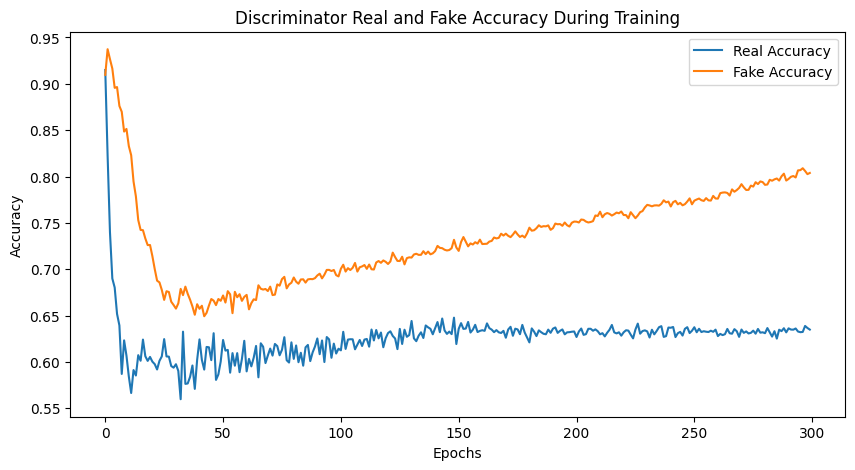

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 300
batch_size = 64
learning_rate = 0.001
g_steps = 1

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, image_size),
            nn.Tanh()
        )
        
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)

total_step = len(train_loader)
start_time = time.time()

d_losses = []
g_losses = []
d_real_accuracies = []
d_fake_accuracies = []

for epoch in range(num_epochs):
    d_loss_epoch = 0.0
    g_loss_epoch = 0.0
    d_real_accuracy_epoch = 0.0
    d_fake_accuracy_epoch = 0.0
    
    for i, (images, _) in enumerate(train_loader):
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)
        
        images = images.view(images.size(0), -1).to(device)
        
        # ================== Train discriminator ================== #
        
        outputs = discriminator(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs.mean().item()
        d_real_accuracy = (outputs > 0.5).float().mean().item()
        
        z = torch.randn(images.size(0), latent_size).to(device)
        fake_images = generator(z)
        
        outputs = discriminator(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs.mean().item()
        d_fake_accuracy = (outputs < 0.5).float().mean().item()
        
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================== Train generator ================== #
        if d_fake_accuracy > 0.99:
            g_steps = 2
        else:
            g_steps = 1

        for _ in range(g_steps):
            z = torch.randn(images.size(0), latent_size).to(device)
            fake_images = generator(z)
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels)
            
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
        
        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()
        d_real_accuracy_epoch += d_real_accuracy
        d_fake_accuracy_epoch += d_fake_accuracy
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}, D Real Acc: {:.2f}, D Fake Acc: {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score, fake_score, d_real_accuracy, d_fake_accuracy))
    
    d_losses.append(d_loss_epoch / total_step)
    g_losses.append(g_loss_epoch / total_step)
    d_real_accuracies.append(d_real_accuracy_epoch / total_step)
    d_fake_accuracies.append(d_fake_accuracy_epoch / total_step)
    
    if (epoch+1) % 1 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_size).to(device)
            fake_images = generator(z).view(-1, 28, 28).cpu().numpy()
            fig, axes = plt.subplots(4, 4, figsize=(8, 8))
            for i, ax in enumerate(axes.flat):
                ax.imshow(fake_images[i], cmap='gray')
                ax.axis('off')
            plt.savefig('v1/generated_images-{}.png'.format(epoch+1))
            plt.close()

end_time = time.time()
print(f'Training finished in {end_time - start_time:.2f} seconds.')

# Plot losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses, label="G")
plt.plot(d_losses, label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot accuracies
plt.figure(figsize=(10, 5))
plt.title("Discriminator Real and Fake Accuracy During Training")
plt.plot(d_real_accuracies, label="Real Accuracy")
plt.plot(d_fake_accuracies, label="Fake Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


Due to fact that discriminator easily overpower generator, for each iteration G is learning twice and D only once. Low learning rate means there is no boots, high rate means everything is a boot. Tried 0.4 dropout for discriminator, in 50th epoch generator starts to easily overperform discriminator (everything is a shoe, t-shirt or trousers)- changed dropout to 0.1. Next step is to determine accuracy treshold in which discriminator should learn another time.

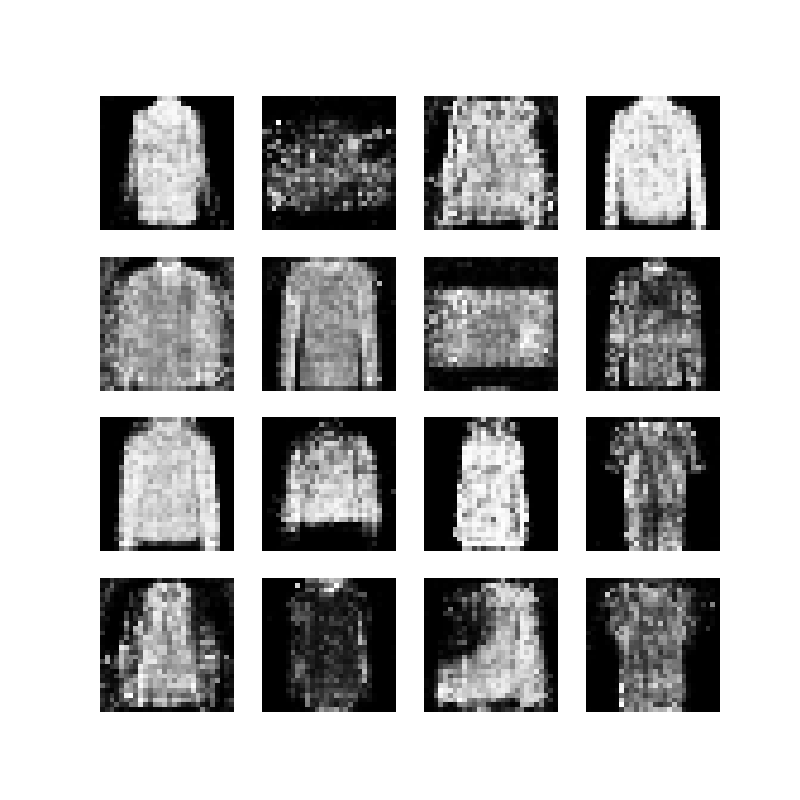
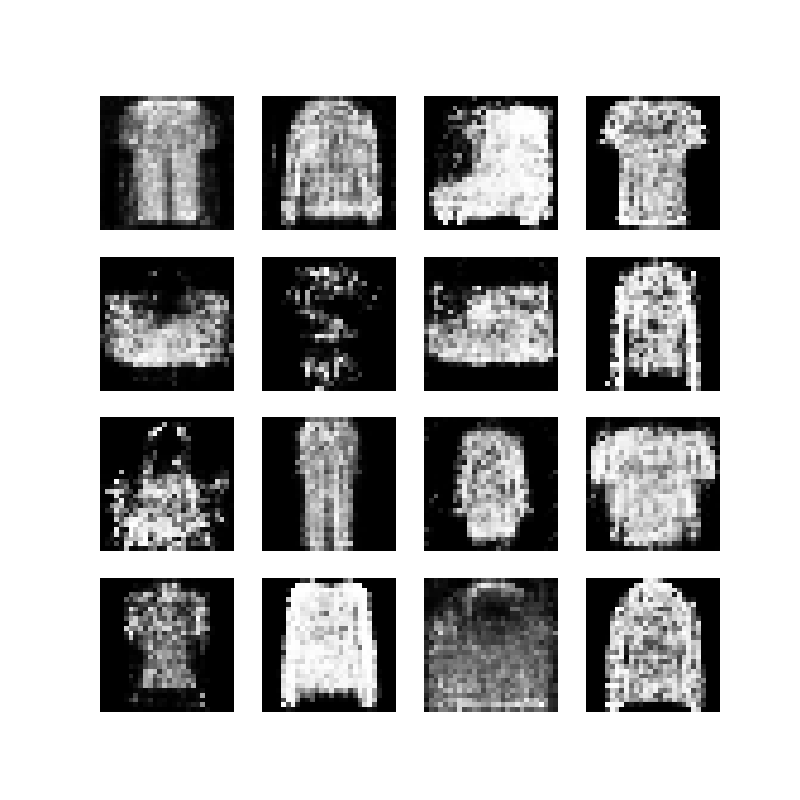

In [7]:
import glob
from PIL import Image
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save("v1.gif", format="GIF", append_images=frames,
               save_all=True, duration=500, loop=1)
make_gif("v1")


In [5]:
torch.save(generator.state_dict(), 'v1/generator.pth')
torch.save(discriminator.state_dict(), 'v1/discriminator.pth')